In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
sub=pd.read_csv('subscription.csv')

In [3]:
sub.head()

,user_id,subscription_signup_date,subscription_monthly_cost,country,source,billing_cycles,is_active
0,1459,"January, 2015",29,Spain,ads,4,0
1,12474,"January, 2015",49,France,ads,5,0
2,12294,"January, 2015",49,Germany,ads,2,0
3,3878,"January, 2015",49,China,ads,1,0
4,9567,"January, 2015",49,UK,ads,5,0


In [4]:
sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 7 columns):
user_id                      500000 non-null int64
subscription_signup_date     500000 non-null object
subscription_monthly_cost    500000 non-null int64
country                      500000 non-null object
source                       500000 non-null object
billing_cycles               500000 non-null int64
is_active                    500000 non-null int64
dtypes: int64(4), object(3)
memory usage: 26.7+ MB


In [5]:
sub.describe(include='all')

,user_id,subscription_signup_date,subscription_monthly_cost,country,source,billing_cycles,is_active
count,500000.000000,500000,500000.000000,500000,500000,500000.000000,500000.000000
unique,NaN,1,NaN,8,3,NaN,NaN
top,NaN,"January, 2015",NaN,US,ads,NaN,NaN
freq,NaN,500000,NaN,91731,414469,NaN,NaN
mean,250000.500000,NaN,48.469620,NaN,NaN,2.384970,0.099998
std,144337.711634,NaN,19.570745,NaN,NaN,2.254952,0.299998
min,1.000000,NaN,29.000000,NaN,NaN,1.000000,0.000000
25%,125000.750000,NaN,29.000000,NaN,NaN,1.000000,0.000000
50%,250000.500000,NaN,49.000000,NaN,NaN,1.000000,0.000000
75%,375000.250000,NaN,49.000000,NaN,NaN,3.000000,0.000000


In [6]:
#Q1: model that predict monthly rentention rate for different subscription price points
## loop through each monthly cost, calculate rention for month 1 throuht month 8.
#list of different prices:
pricelist=np.unique(sub['subscription_monthly_cost'])
rtn_dict={}

for price in pricelist:
    rtn=[]
    user_num=len(sub[sub['subscription_monthly_cost']==price])
    for i in range(1,9):
        rate=len(sub[(sub['subscription_monthly_cost']==price) & (sub['billing_cycles']>=i)])/float(user_num)
        rtn.append(rate)
    rtn_dict[price]=rtn

rtn_df=pd.DataFrame(rtn_dict)

In [7]:
rtn_df.index=range(1,9)

In [8]:
rtn_df

,29,49,99
1,1.000000,1.000000,1.000000
2,0.607542,0.383666,0.158769
3,0.458473,0.206247,0.070040
4,0.376232,0.134043,0.042411
5,0.323028,0.096466,0.029676
6,0.285416,0.074072,0.022182
7,0.257157,0.059408,0.017937
8,0.235901,0.048845,0.015007


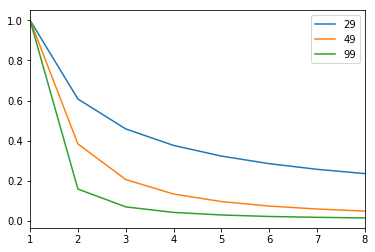

In [9]:
rtn_df.plot()

In [10]:
## from the plot one can see that the subscription rate drops exponentially with time.

## to model the rentention rate, set up y=A*exp(-B*x), transform all rentention rate to log (rentention_rate) for linear reg.

rtn_df.rename(columns={29:'price_29', 49: 'price_49', 99: 'price_99'}, inplace=True)

rtn_df_log=np.log(rtn_df)

In [11]:
rtn_df_log

,price_29,price_49,price_99
1,0.000000,0.000000,0.000000
2,-0.498335,-0.957984,-1.840307
3,-0.779854,-1.578680,-2.658689
4,-0.977551,-2.009597,-3.160349
5,-1.130017,-2.338568,-3.517404
6,-1.253809,-2.602718,-3.808467
7,-1.358069,-2.823326,-4.020873
8,-1.444341,-3.019096,-4.199223


In [12]:
rtn_log=rtn_df_log.stack().reset_index()

In [13]:
rtn_log.columns=['month','price_lvl','rtn']
rtn_log=pd.get_dummies(rtn_log)
rtn_log.columns=['month','rtn','pr_29','pr_49','pr_99']
rtn_log.head()

,month,rtn,pr_29,pr_49,pr_99
0,1,0.000000,1,0,0
1,1,0.000000,0,1,0
2,1,0.000000,0,0,1
3,2,-0.498335,1,0,0
4,2,-0.957984,0,1,0


### Linear Regression with month, one-hot encoded price levels and log(rentention rate)

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model=LinearRegression()
model.fit(rtn_log[['month','pr_29','pr_49','pr_99']], rtn_log['rtn'])
pred=model.predict(rtn_log[['month','pr_29','pr_49','pr_99']])

print(model.coef_, model.intercept_)
print('RMSE: %.4f' % np.sqrt(mean_squared_error(rtn_log['rtn'], pred)) )

[-3.72812030e-01  9.85472124e-01 -5.27119343e-04 -9.84945005e-01] -0.23806490271669123
RMSE: 0.4729


### Linear Regression with month, price as two features and log(rentention) as y

In [15]:
rtn_new=rtn_df_log.stack().reset_index()
rtn_new.columns=['month','price_lvl','rtn']

In [16]:
rtn_new['price']=rtn_new['price_lvl'].map({'price_29':29, 'price_49':49, 'price_99':99})

In [17]:
rtn_new=rtn_new.drop('price_lvl', axis=1)

In [18]:
rtn_new.head()

,month,rtn,price
0,1,0.000000,29
1,1,0.000000,49
2,1,0.000000,99
3,2,-0.498335,29
4,2,-0.957984,49


In [19]:
model2=LinearRegression()
model2.fit(rtn_new[['month','price']], rtn_new['rtn'])
pred2=model2.predict(rtn_new[['month','price']])

print(model2.coef_, model2.intercept_)
print('RMSE: %.4f' % np.sqrt(mean_squared_error(rtn_new['rtn'], pred2)) )

[-0.37281203 -0.0265218 ] 1.3267215856589596
RMSE: 0.5110


#### Create x, x^2 and log(x) features and do linear regression for 3 different price groups on log (rentention)

In [25]:
x=np.array(range(1,9))
x2=x**2
log_x=np.log(x)
features=pd.DataFrame({'x':x, 'x2':x2, 'log_x':log_x})

In [48]:
rtn_df=rtn_df.reset_index(drop=True)

In [50]:
new_df=pd.concat((features, rtn_df), axis=1)


In [52]:
model29=LinearRegression()
model49=LinearRegression()
model99=LinearRegression()

model29.fit(new_df[['x','x2','log_x']], np.log(new_df['price_29']))
model49.fit(new_df[['x','x2','log_x']], np.log(new_df['price_49']))
model99.fit(new_df[['x','x2','log_x']], np.log(new_df['price_99']))

pred29=model29.predict(new_df[['x','x2','log_x']])
pred49=model49.predict(new_df[['x','x2','log_x']])
pred99=model99.predict(new_df[['x','x2','log_x']])

RMSE=np.sqrt(np.mean([mean_squared_error(np.log(new_df['price_29']), pred29), 
                     mean_squared_error(np.log(new_df['price_49']), pred49),
                    mean_squared_error(np.log(new_df['price_99']), pred99)]))

print('RMSE: %.4f' % RMSE )

RMSE: 0.0114


In [53]:
## predict percentage of users still subscribed after 12 months
print('predicted user rention at 12 month for $29 plan: {:.4f}'.format(np.exp(model29.predict([[12, 12**2, np.log(12)]])[0])))
print('predicted user rention at 12 month for $49 plan: {:.4f}'.format(np.exp(model49.predict([[12, 12**2, np.log(12)]])[0])))
print('predicted user rention at 12 month for $99 plan: {:.4f}'.format(np.exp(model99.predict([[12, 12**2, np.log(12)]])[0])))

predicted user rention at 12 month for $29 plan: 0.1789
predicted user rention at 12 month for $49 plan: 0.0321
predicted user rention at 12 month for $99 plan: 0.0056


In [55]:
x=np.array(range(1, 13))
x2=x**2
log_x=np.log(x)

features_=pd.DataFrame({'x':x, 'x2':x2, 'log_x': log_x})
features_['pred29']=np.exp(model29.predict(features_[['x','x2','log_x']]))
features_['pred49']=np.exp(model49.predict(features_[['x','x2','log_x']]))
features_['pred99']=np.exp(model99.predict(features_[['x','x2','log_x']]))

features_


,x,x2,log_x,pred29,pred49,pred99
0,1,1,0.000000,0.999502,1.003844,0.992027
1,2,4,0.693147,0.608619,0.378064,0.163419
2,3,9,1.098612,0.458101,0.208259,0.069098
3,4,16,1.386294,0.375765,0.135129,0.041513
4,5,25,1.609438,0.322898,0.096500,0.029441
5,6,36,1.791759,0.285608,0.073590,0.022695
6,7,49,1.945910,0.257606,0.058968,0.018197
7,8,64,2.079442,0.235610,0.049174,0.014781
8,9,81,2.197225,0.217726,0.042412,0.011960
9,10,100,2.302585,0.202786,0.037674,0.009529


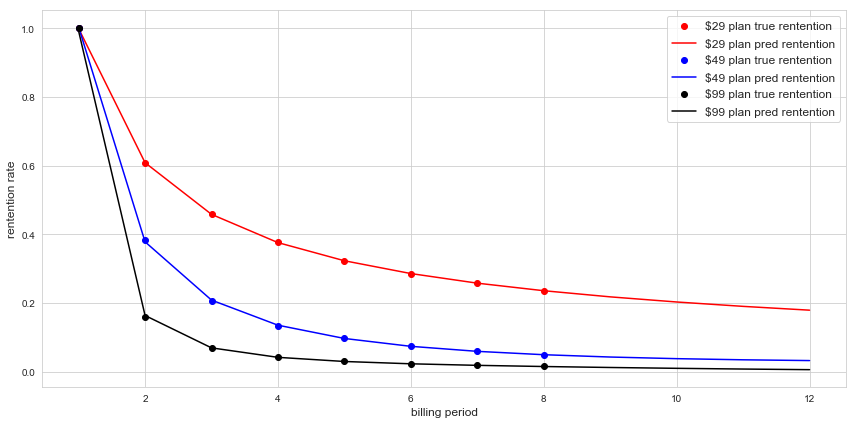

In [60]:
fig, ax=plt.subplots(figsize=(12, 6))
ax.plot(new_df['x'], new_df['price_29'], 'ro', label='$29 plan true rentention')
ax.plot(features_['x'], features_['pred29'],'r-', label='$29 plan pred rentention')
ax.plot(new_df['x'], new_df['price_49'], 'bo', label='$49 plan true rentention')
ax.plot(features_['x'], features_['pred49'],'b-', label='$49 plan pred rentention')
ax.plot(new_df['x'], new_df['price_99'], 'ko', label='$99 plan true rentention')
ax.plot(features_['x'], features_['pred99'],'k-', label='$99 plan pred rentention')

ax.set_xlabel('billing period', fontsize=12)
ax.set_ylabel('rentention rate', fontsize=12)
ax.legend(fontsize=12)

plt.tight_layout()
plt.show()

In [21]:
## Explore the influence of country and source on rentention

import seaborn as sns
sns.set_style('whitegrid')

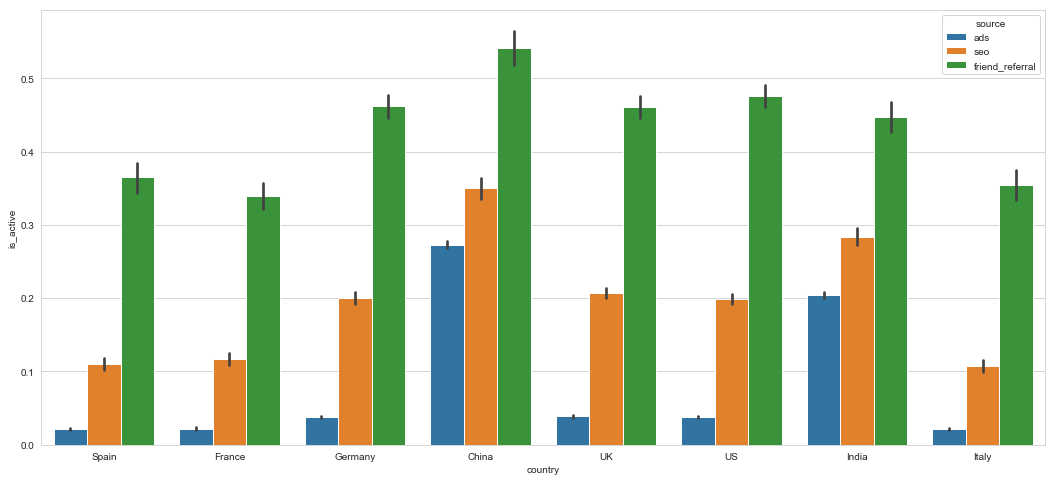

In [22]:
plt.figure(figsize=(18,8))
sns.barplot(x='country', y='is_active',hue='source', data=sub)

#### one can see that for all countrys, friend_referalls has the highest rentention, 2nd is the SEO and ads is the 3rd.
This means we should invest more in getting users to refer their friends and family to join our subscription program. For example, we can send emails to users asking them to refer friends and reward them for each successful referral.

Also, it seems the users subscribed through ads do not have high retention: are our ads exaggerated? are users leaving because whatever is promised in the ads not meeting their expectations? We should re-examine and improve the ads and make sure what is advertised is on-par with what is actually available.

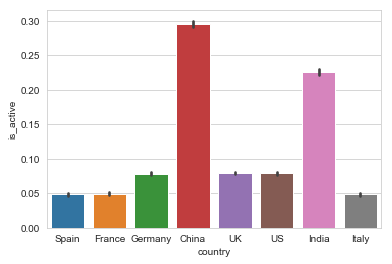

In [23]:
sns.barplot(x='country', y='is_active', data=sub)

#### China and India has the highest rentention rate (>0.20) while the rest are below 0.10. We should survey the customers in China and India and figure out what exactly is keeping them around and make sure that feature is implemented correctly in the rest. We need to improve engagement in those countries (e.g, build customized programs, giving promotions, etc.) to improve our rentention. This will help improve our revenue.